### MARS Knowledge Graph 

In [1]:
import torch
from transformers import CLIPProcessor, CLIPModel
import matplotlib.pyplot as plt
import networkx as nx
import torch.nn.functional as F

/home/sha/anaconda3/envs/dvaa/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### 0. Setting

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [3]:
clip_model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32").to(device)
clip_processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")

In [4]:
@torch.no_grad()
def get_clip_image_embeddings(images, clip_processor, clip_model, device):
    inputs = clip_processor(images=images, return_tensors="pt").to(device)
    return clip_model.get_image_features(**inputs) # [num of images, dimenstion]

@torch.no_grad()
def get_clip_text_embeddings(texts, clip_processor, clip_model, device):
    inputs = clip_processor(text=texts, return_tensors="pt", padding=True).to(device)
    return clip_model.get_text_features(**inputs) # [num of texts, dimenstion]

---

#### 1. Construct {entity, relation} dictionary

In [5]:
entity_dict = {}
with open("MarKG/entity2text.txt", "r") as enidf:
    for line in enidf.readlines():
        entity_dict[line.split('\t')[0]] = line.split('\t')[1][:-1]
print(entity_dict)

{'Q14942930': 'WikiProject Painting', 'Q262': 'Algeria', 'Q15602263': 'Michelia alba', 'Q183904': 'mammalogy', 'Q10053880': 'Category:Orchards', 'Q55784387': 'short stature-onychodysplasia-facial dysmorphism-hypotrichosis syndrome', 'Q10351538': 'intercardinal direction', 'Q43483': 'well', 'Q7217296': 'Category:Antarctica', 'Q735188': 'protein structure', 'Q6452640': 'southeast', 'Q47521464': 'Desoxyn', 'Q2811': 'submarine', 'Q105467331': 'science student', 'Q6072584': 'quail', 'Q123371': 'Hans Albert Einstein', 'Q9231048': 'Category:Odds BK', 'Q25272': 'ampere', 'Q24905683': 'disincentive', 'Q17991228': 'national defence', 'Q724520': 'Jintan District', 'Q849363': 'The Vanguard Group', 'Q13479477': 'Template:War', 'Q55248783': 'Category:Microwave ovens', 'Q775318': 'internaut', 'Q6189617': 'jewelry design', 'Q129026': 'great white shark', 'Q6449083': 'Category:Pittsburgh', 'Q3051005': 'Eliminate Down', 'Q207123': 'herb', 'Q877998': "students' union", 'Q58734': 'pollution', 'Q47185282':

In [6]:
relation_dict = {}
with open("MarKG/relation2text.txt", "r") as enidf:
    for line in enidf.readlines():
        relation_dict[line.split('\t')[0]] = line.split('\t')[1][:-1]
print(relation_dict)

{'P276': 'location', 'P47': 'shares border with', 'P140': 'religion or worldview', 'P910': "topic's main category", 'P279': 'subclass of', 'P101': 'field of work', 'P1889': 'different from', 'P155': 'follows', 'P1343': 'described by source', 'P31': 'instance of', 'P3095': 'practiced by', 'P2283': 'uses', 'P5008': 'on focus list of Wikimedia project', 'P2852': 'emergency phone number', 'P1056': 'product or material produced', 'P1792': 'category of associated people', 'P131': 'located in the administrative territorial entity', 'P2853': 'electrical plug type', 'P27': 'country of citizenship', 'P21': 'sex or gender', 'P2341': 'indigenous to', 'P460': 'said to be the same as', 'P366': 'has use', 'P159': 'headquarters location', 'P17': 'country', 'P1464': 'category for people born here', 'P527': 'has part(s)', 'P530': 'diplomatic relation', 'P1151': "topic's main Wikimedia portal", 'P1433': 'published in', 'P112': 'founded by', 'P5125': 'Wikimedia outline', 'P1995': 'health specialty', 'P105

---

#### 2. Construct Knowledge Graph (KG)

2-1. Construct triple form : [entity(head)-relation-entity(tail)]

In [7]:
KG = []

with open("MarKG/wiki_tuple_ids.txt", "r") as enidf:
    for line in enidf.readlines():
        entity1 = entity_dict[line.split('\t')[0]]
        entity2 = entity_dict[line.split('\t')[2][:-1]]
        relation = relation_dict[line.split('\t')[1]]
        KG.append((entity1, relation, entity2))
print(len(KG))
print(KG)

33307
[('chair', 'location', 'space'), ('Russian Empire', 'shares border with', 'United States of America'), ('parish church', 'religion or worldview', 'Christianity'), ('Shanghai', "topic's main category", 'Category:Shanghai'), ('causeway', 'subclass of', 'geographical feature'), ('guide dog', 'field of work', 'health care'), ('petroleum industry', 'subclass of', 'industry'), ('number line', 'different from', 'line'), ('childhood', 'follows', 'parturition'), ('investigative journalism', 'subclass of', 'journalism'), ('milk', 'described by source', 'Ottův slovník naučný'), ('Loose', 'instance of', 'Wikimedia disambiguation page'), ('mining', 'practiced by', 'miner'), ('home appliance', 'uses', 'electricity'), ('coyote', 'on focus list of Wikimedia project', 'WikiProject Invasion biology'), ('Kingdom of Italy', 'instance of', 'sovereign state'), ('Germany', 'emergency phone number', '112'), ('vertebrate', 'instance of', 'organisms known by a particular common name'), ('The Walt Disney C

2-2. find entities and relations

In [8]:
KG_entities = sorted(list({h for h, _, _ in KG} | {t for _, _, t in KG}))
KG_relations = sorted(list({r for _, r, _ in KG}))
print('Num of Entities:', len(KG_entities))
print('Num of relations:', len(KG_relations))

Num of Entities: 9903
Num of relations: 191


2-3. construct Adjency List

In [9]:
'''
* {entity_i: {entity_j: relation_ij, entity_k: relation_ik}, ...}
* example: {'apple': {'yellow': 'color, 'food': 'subclass of'}, ...}
'''
ad_list = {}
for head, rel, tail in KG:
    if head not in ad_list:
        ad_list[head] = {tail: rel}
    else:
        ad_list[head][tail] = rel

In [10]:
# search example
head = 'apple'

if head in ad_list:
    head_connection = ad_list[head]
    for nbr in head_connection:
        rel = head_connection[nbr]
        print(f'({head})-({rel})-({nbr})')
else:
    print(f'There is no [{head}] in adjenncy list.')

(apple)-(color)-(yellow)
(apple)-(on focus list of Wikimedia project)-(Wikipedia:List of articles all languages should have)
(apple)-(subclass of)-(fruit)
(apple)-(different from)-(Elma)
(apple)-(subclass of)-(food)
(apple)-(natural product of taxon)-(Malus)
(apple)-(subclass of)-(pome)
(apple)-(has part(s))-((R)-amygdalin)
(apple)-(described by source)-(Paulys Realenzyklopädie der klassischen Altertumswissenschaft)
(apple)-(color)-(green)
(apple)-(has quality)-(color)
(apple)-(topic's main category)-(Category:Apples)
(apple)-(described by source)-(Metropolitan Museum of Art Tagging Vocabulary)
(apple)-(described by source)-(Gujin Tushu Jicheng)


---

#### 3. Retrieve Sub-KG

3-1. Query Embedding

In [11]:
query = 'Combustion'
query_embed = get_clip_text_embeddings([query], clip_processor, clip_model, device)
print(query_embed.shape)

torch.Size([1, 512])


3-2. Entity Embedding

In [12]:
def get_ranges(n, interval):
    ranges = []
    for start in range(0, n, interval):
        if start + interval > n:
            end = n
        else:
            end = start + interval
        ranges.append((start, end))
    return ranges

In [13]:
clip_ranges = get_ranges(len(KG_entities), 1000) # [0,1000], [1000, 2000], ...

kge_embed_list = []
for clip_range in clip_ranges:
    start, end = clip_range[0], clip_range[1]
    kge_embed = get_clip_text_embeddings(KG_entities[start:end], clip_processor, clip_model, device) # [1000, dimension]
    kge_embed_list.append(kge_embed)
kge_embed_tensor = torch.cat(kge_embed_list, dim=0)
print(kge_embed_tensor.shape)

torch.Size([9903, 512])


3-3. Find Sub-entities related to Query

In [14]:
# normalize
query_embed_norm = F.normalize(query_embed, dim=1)
kge_embed_norm = F.normalize(kge_embed_tensor, dim=1)

# cosine similarity
similarity = query_embed_norm @ kge_embed_norm.T  # (1, 9903)

# Top-n indices search (n=10)
_, topn_indices = similarity.squeeze(1).topk(10, largest=True)
topn_indices_np = topn_indices[0].cpu().numpy()

# print Top-n entity
sub_entities = [KG_entities[i] for i in topn_indices_np]
print('sub_entities:', sub_entities)

sub_entities: ['combustion', 'Category:Combustion', 'burning', 'conflagration', 'fire', 'fossil fuel combustion', 'flame', 'combustible matter', 'flammability', 'combustibility']


3-4. Contruct Sub-KG using sub-entities

In [15]:
sub_KG = []

for se in sub_entities:
    if se in ad_list:
        se_connection = ad_list[se]
        for nbr in se_connection:
            rel = se_connection[nbr]
            sub_KG.append((se, rel, nbr))    
    
print(len(sub_KG))    
print('sub_graph:', sub_KG)

49
sub_graph: [('combustion', 'facet of', 'thermal energy'), ('combustion', 'said to be the same as', 'burning'), ('combustion', "topic's main category", 'Category:Combustion'), ('combustion', 'described by source', 'Armenian Soviet Encyclopedia'), ('combustion', 'uses', 'combustible matter'), ('combustion', 'uses', 'oxidizing agent'), ('combustion', 'subclass of', 'redox'), ('combustion', 'has effect', 'fire'), ('burning', 'different from', 'roasting'), ('burning', 'subclass of', 'burning'), ('burning', 'subclass of', 'process'), ('burning', 'described by source', 'Armenian Soviet Encyclopedia'), ('burning', 'part of', 'pottery'), ('burning', 'subclass of', 'production process'), ('conflagration', 'described by source', 'Sytin Military Encyclopedia'), ('conflagration', 'subclass of', 'disaster'), ('conflagration', 'subclass of', 'fire'), ('conflagration', 'described by source', 'Gujin Tushu Jicheng'), ('conflagration', 'described by source', 'Ottův slovník naučný'), ('conflagration', 

3-5. Sub-KG Filtering

In [16]:
# get text in sub-graph
sg_text_list = []
for item in sub_KG:
    text = f'{item[0]}-{item[1]}-{item[2]}'
    sg_text_list.append(text)

# get text embedding
sgt_embed = get_clip_text_embeddings(sg_text_list, clip_processor, clip_model, device) # [49, dimension]
sgt_embed_norm =  F.normalize(sgt_embed, dim=1)

# cosine similarity
re_similarity = query_embed_norm @ sgt_embed_norm.T  # (1, 49)

# Top-N indices search (N=10)
_, re_topn_indices = re_similarity.squeeze(1).topk(10, largest=True)
re_topn_indices_np = re_topn_indices[0].cpu().numpy()

# sib-graph filtering
f_sub_KG = [sub_KG[i] for i in re_topn_indices_np]
print(len(f_sub_KG))    
print('filtered_sub_graph:', f_sub_KG)

10
filtered_sub_graph: [('combustion', 'has effect', 'fire'), ('combustion', 'said to be the same as', 'burning'), ('fire', 'has cause', 'combustion'), ('combustion', "topic's main category", 'Category:Combustion'), ('combustible matter', 'has quality', 'combustion'), ('combustion', 'uses', 'combustible matter'), ('flame', 'part of', 'fire'), ('combustion', 'facet of', 'thermal energy'), ('combustible matter', 'manifestation of', 'combustibility'), ('fire', 'subclass of', 'physical phenomenon')]


---

#### 4. Sub-KG Visualization

In [17]:
def draw_knowledge_graph(KG, query, seed=42):
    G = nx.DiGraph()
    for h, r, t in KG:
        G.add_node(h)
        G.add_node(t)
        G.add_edge(h, t, label=r)

    pos = nx.spring_layout(G, seed=seed)

    plt.figure(figsize=(10, 6))
    nx.draw(G, pos, with_labels=True, node_size=3000, node_color='skyblue',
            font_size=10, edge_color='gray', arrows=True)

    edge_labels = nx.get_edge_attributes(G, 'label')
    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_color='red')

    title=f"Retrieved Knowledge Graph (Query: {query})"
    plt.title(title)
    plt.axis('off')
    plt.tight_layout()
    plt.show()

sub-KG (non-filtered: 49 edges)


/tmp/ipykernel_1567448/3981973353.py:20: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


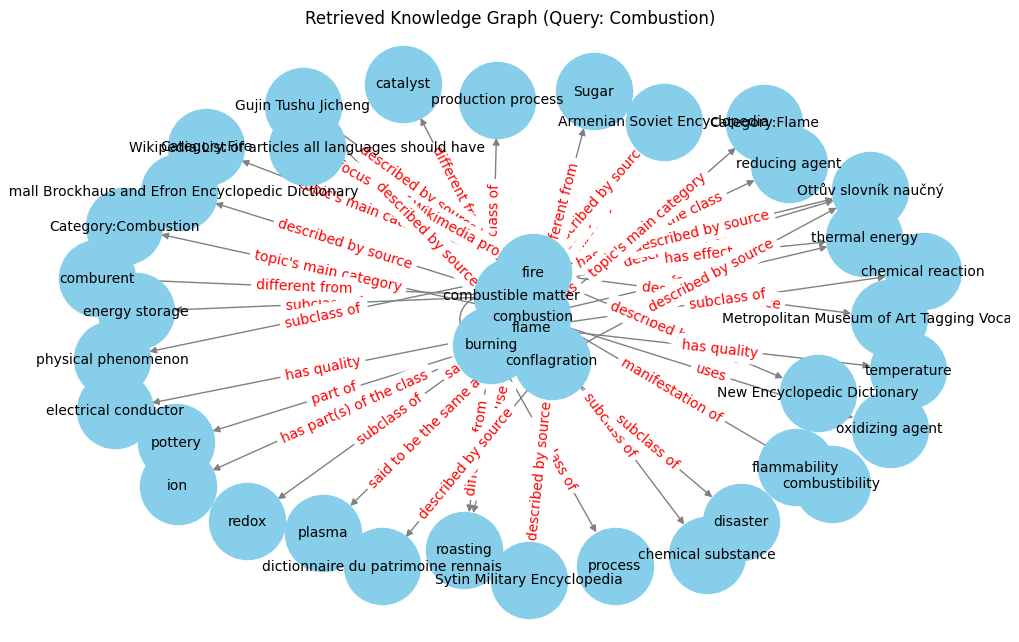

sub-KG (filtered: 10 edges)


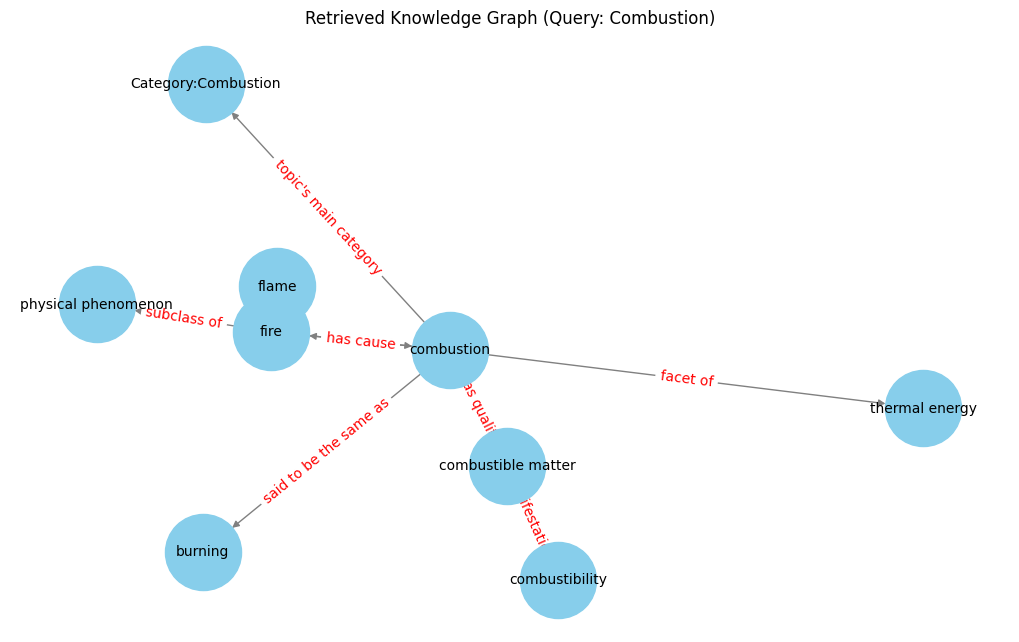

In [18]:
print(f'sub-KG (non-filtered: {len(sub_KG)} edges)')
draw_knowledge_graph(sub_KG, query)

print(f'sub-KG (filtered: {len(f_sub_KG)} edges)')
draw_knowledge_graph(f_sub_KG, query)